In [1]:
import healpy as hp
import numpy as np

from astropy import units as u
from astropy import constants as c

import matplotlib.pyplot as plt

import camb
from camb import model, initialpower

## The Cosmic Microwave Background (CMB) - Overview

The Cosmic Microwave Background (CMB) is a relic radiation leftover from the Big Bang, which occurred around 13.8 billion years ago. It provides crucial information about the early universe and has been used as a powerful tool to study its geometry and composition. The curvature of the universe is an important aspect of its geometry and can be classified into three categories: flat, positively curved (spherical), and negatively curved (hyperbolic).

Measuring the curvature of the universe through the CMB involves analyzing its temperature fluctuations. These fluctuations represent tiny differences in temperature (about 1 part in 100,000) that are caused by variations in density in the early universe.

To measure these fluctuations, scientists use instruments like the Wilkinson Microwave Anisotropy Probe (WMAP) and the Planck satellite. These instruments observe the CMB radiation and create detailed maps of its temperature fluctuations across the sky. From these maps, scientists can derive important cosmological parameters.

One key observable in the CMB is the angular power spectrum, which characterizes the distribution of temperature fluctuations at different angular scales. The angular power spectrum displays a series of peaks and troughs. The position and height of these peaks are sensitive to several cosmological parameters, including the curvature of the universe.

The first peak of the angular power spectrum is particularly important, as it corresponds to the largest angular scale at which temperature fluctuations are observed. The position of this peak is sensitive to the overall geometry of the universe. In a flat universe, the peak appears at an angular scale of about 1 degree, while in a positively or negatively curved universe, the peak shifts to larger or smaller angular scales, respectively.

By analyzing the position of the first peak in the CMB angular power spectrum, scientists have been able to put tight constraints on the curvature of the universe. The latest results from the Planck satellite suggest that the universe is very close to being flat, with a curvature close to zero.

However, it is important to note that these measurements are still subject to uncertainties and potential systematic errors. Future observations with more advanced instruments may help to refine our understanding of the universe's curvature and other cosmological parameters.

## Plot Observed angular power spectrum (data from Planck satellite)

#### Downloading CMB Data

Download CMB data from the Planck Legacy Archive (PLA): https://pla.esac.esa.int/. 

Create an account and select "CMB maps" from the Planck Legacy Archive. The CMB maps have already been cleaned of foreground emissions, which means they have been processed to remove the contributions of sources such as galactic dust, synchrotron radiation, and other non-CMB signals. This makes them more suitable for studying the properties of the CMB, such as the angular power spectrum.

After you select "CMB maps," you will see a list of available maps. You may choose the "COM_CMB_IQU-smica_2048_R3.00_full.fits" file, which is a full-sky CMB map produced by the Planck collaboration using the SMICA (Spectral Matching Independent Component Analysis) method. This map combines data from multiple frequency channels to isolate the CMB signal from other astrophysical emissions.

COM_CMB_IQU-smica_2048_R3.00_full.fits file contains a full-sky map of the Cosmic Microwave Background (CMB) temperature and polarization anisotropies derived from the Planck satellite data. The temperature values in this map are in units Kelvin

Also available from
https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits

In [2]:
# Load the CMB map (for example, the Planck 2018 SMICA map)
cmb_map_file = "data/COM_CMB_IQU-smica_2048_R3.00_full.fits"
cmb_map = hp.read_map(cmb_map_file, field=0)  # field=0 for the temperature map

# Remove the monopole and dipole components
cmb_map = hp.remove_dipole(cmb_map)

# Compute the angular power spectrum
lmax = 2500  # Maximum multipole to consider
cl_observed = hp.anafast(cmb_map, lmax=lmax)

# output above is in Kelvin**2.  Convert this to microKelvin**2
cl_observed = (cl_observed * u.K**2).to(u.uK**2)

# Normalize this with respect to solid angle.
cl_observed /= 2*np.pi

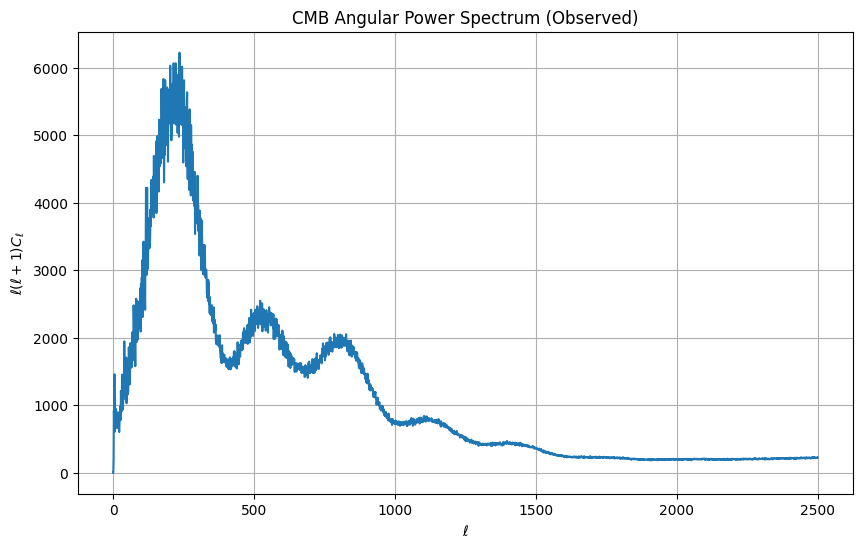

In [3]:
# Create an array of multipole moments (l)
ell_observed = np.arange(len(cl_observed))

# Plot the angular power spectrum
plt.figure(figsize=(10, 6))
plt.plot(ell_observed, ell_observed * (ell_observed + 1) * cl_observed)
plt.xlabel("$\ell$")
plt.ylabel("$\ell (\ell + 1) C_\ell$")
plt.title("CMB Angular Power Spectrum (Observed)")
plt.grid()
plt.show()

## Compare Observed Against Theoretical Models

To model the angular power spectrum of the CMB for different cosmological models, you can use the Python library called CAMB (Code for Anisotropies in the Microwave Background). CAMB is a widely used tool to calculate the theoretical power spectra for various cosmological models, including the CMB temperature and polarization power spectra, as well as the matter power spectrum.

In [4]:
def generate_power_spectrum_for_cosmology(cosmology):
    # Set up CAMB parameters
    params = camb.CAMBparams()
    params.set_cosmology(H0=cosmology['H0'], ombh2=cosmology['ombh2'], omch2=cosmology['omch2'], 
                       mnu=cosmology['mnu'], omk=cosmology['omk'])
    params.InitPower.set_params(As=cosmology['As'], ns=cosmology['ns'])
    params.set_for_lmax(2500, lens_potential_accuracy=0)
    
    #calculate results for these parameters
    results = camb.get_results(params)

    #get dictionary of CAMB power spectra
    powers = results.get_cmb_power_spectra(params, CMB_unit='muK')

    # No additional scaling needed after this.
    return powers['total'][:,0]    

In [21]:
# Planck 2018 parameters
Planck2018 = {
    'H0': 67.66,          # Hubble constant
    'ombh2': 0.02242,      # Baryon density parameter
    'omch2': 0.11933,      # Cold dark matter density parameter
    'mnu': 0.06,          # Sum of neutrino masses
    'omk': 0,             # Curvature parameter
    'tau': 0.0561,        # Optical depth
    'As': 2.105e-9,       # Amplitude of the primordial spectrum
    'ns': 0.9665,         # Scalar spectral index
}

cl_Planck2018 = generate_power_spectrum_for_cosmology(Planck2018)
ell_Planck2018 = np.arange(len(cl_Planck2018))

# Experiment parameters
Experiment = {
    'H0': 67.66,          # Hubble constant
    'ombh2': 0.02242,      # Baryon density parameter
    'omch2': 0.11933,      # Cold dark matter density parameter
    'mnu': 0.06,          # Sum of neutrino masses
    'omk': 0,             # Curvature parameter
    'tau': 0.0561,        # Optical depth
    'As': 2.105e-9,       # Amplitude of the primordial spectrum
    'ns': 0.9665,         # Scalar spectral index
}

cl_Experiment = generate_power_spectrum_for_cosmology(Experiment)
ell_Experiment = np.arange(len(cl_Experiment))

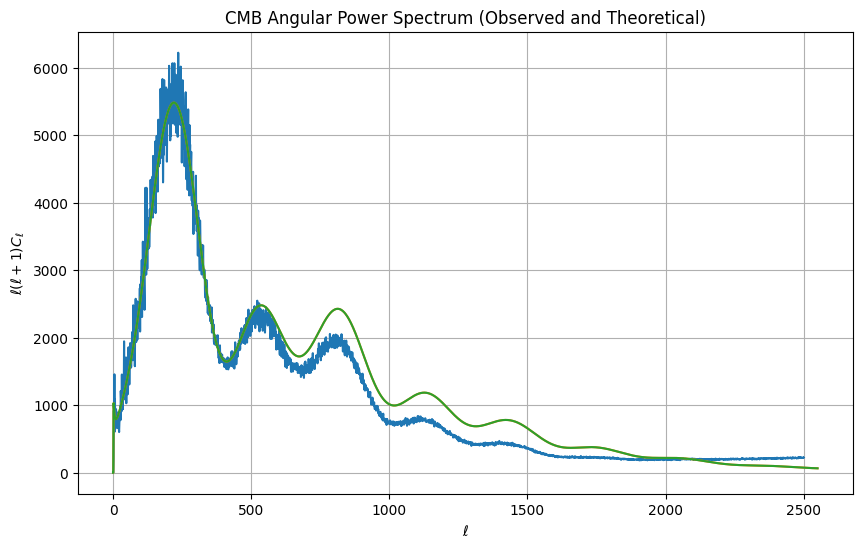

In [22]:
# Plot the angular power spectrum
plt.figure(figsize=(10, 6))
plt.plot(ell_observed, ell_observed * (ell_observed + 1) * cl_observed)
plt.plot(ell_Planck2018, cl_Planck2018)
plt.plot(ell_Experiment, cl_Experiment)
plt.xlabel("$\ell$")
plt.ylabel("$\ell (\ell + 1) C_\ell$")
plt.title("CMB Angular Power Spectrum (Observed and Theoretical)")
plt.grid()
plt.show()